In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
import pandas as pd
import seaborn as sns
import statsmodels
import numpy as np
from pathlib import Path
from datetime import datetime
from scipy.stats import shapiro
import statsmodels.api as sm
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from matplotlib import pyplot as plt

In [3]:
# import modules
from src.features import stat_tests as st
from src.features import calculate_chart_params as cp
from src.features import functions as fn
from src.features import plot_functions as pf

In [4]:
%matplotlib inline

#### Read in data

In [5]:
data_path = "D:\\Users\\Nicholas\\Projects\\repos\\spc_charts\\data\\raw\\diabetes\\Diabetes-Data"

In [6]:
data_files = [i for i in os.listdir(data_path) if 'data-' in i]

In [7]:
def read_data(path):
    data = pd.read_table(path, header=None)
    data.columns = ['Date', 'Time', 'Code', 'Value']
    return data

In [8]:
data = pd.DataFrame(columns = ['Date', 'Time', 'Code', 'Value'])

for i in range(len(data_files)):
    temp = read_data(Path(data_path) / data_files[i])
    data = data.append(temp, ignore_index=True)

#### Subset data to blood glucose measurement

In [9]:
data_sub = data.loc[data['Code'].isin([48, 57, 58, 59, 60, 61, 62, 63, 64]), :].copy()

In [10]:
data_sub['Date'] = data_sub['Date'] + ' ' + data_sub['Time'] 

In [11]:
data_sub['Date'] = pd.to_datetime(data_sub['Date'], errors='coerce')

In [12]:
data_sub['Value'] = pd.to_numeric(data_sub['Value'], errors='coerce')

In [13]:
data_sub = data_sub.dropna()

#### Aggregate by date

In [14]:
data_sub_day = data_sub.groupby(pd.Grouper(key='Date', freq='d')).agg(mean = ('Value', 'mean'), 
                                                                      sd = ('Value', 'std'),
                                                                      n = ('Value', 'count'))

In [15]:
data_sub_day = data_sub_day.dropna()

In [16]:
data_sub_day = data_sub_day.reset_index()

#### Subset data to a smaller set

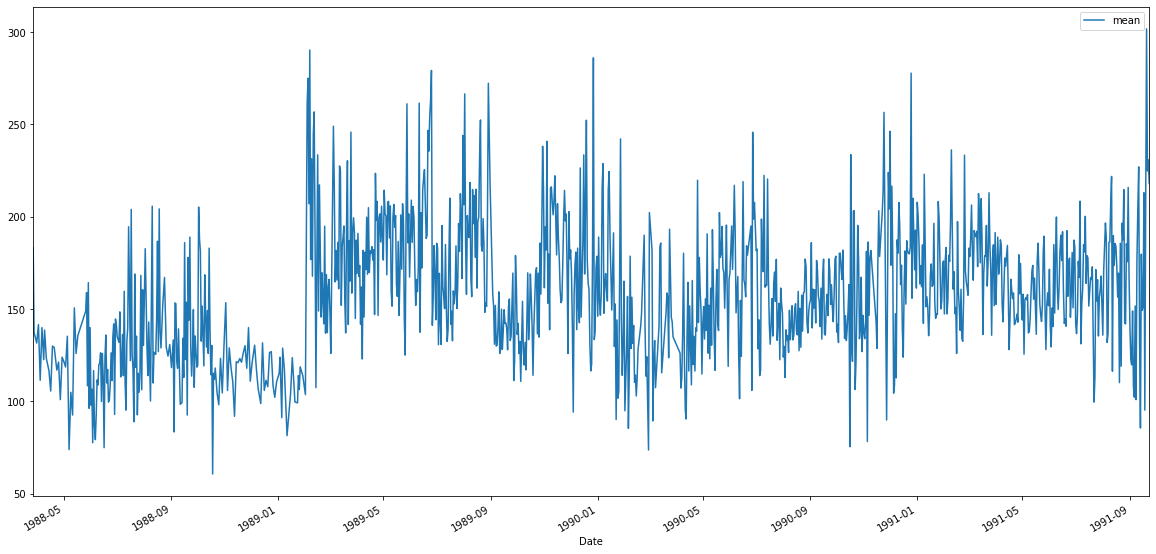

In [17]:
data_sub_day.plot.line(x='Date', y='mean', figsize=(20,10))

In [18]:
date_filter = (data_sub_day['Date'] >= '1989-09') & (data_sub_day['Date'] < '1989-11-06')

In [19]:
date_cutoff = '1989-10-15'

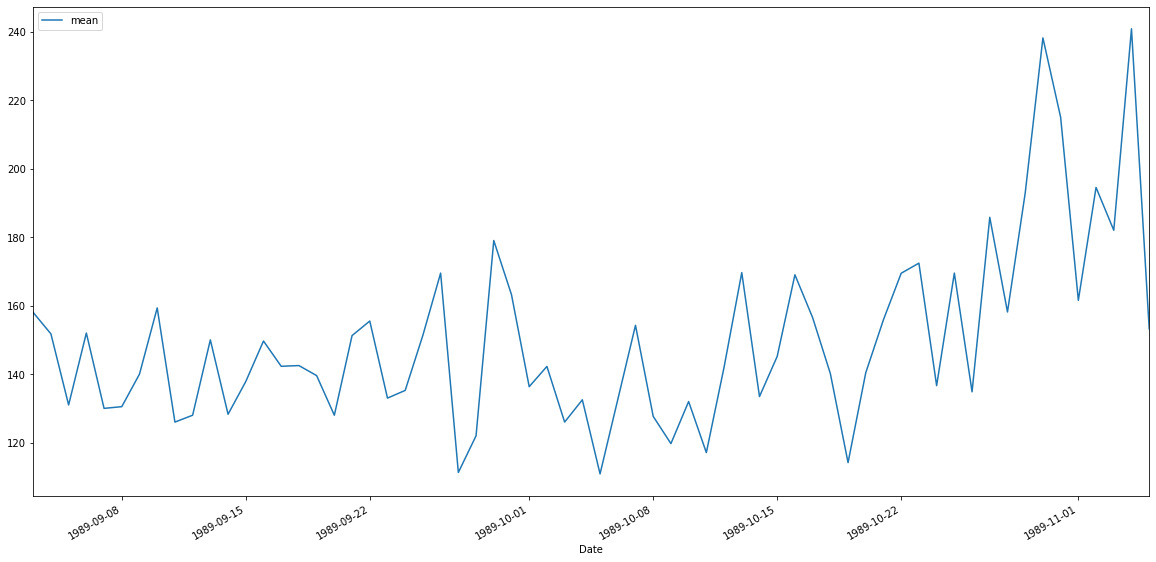

In [20]:
data_sub_day[date_filter].plot.line(x='Date', y='mean', figsize=(20,10))

In [21]:
data_sub_day = data_sub_day[date_filter].copy()

#### Hypothesis test for autocorrelation

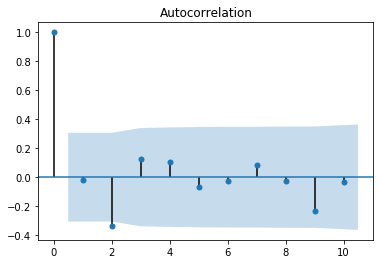

In [22]:
_ = plot_acf(data_sub_day.loc[data_sub_day['Date'] < date_cutoff, 'mean'], lags=10)

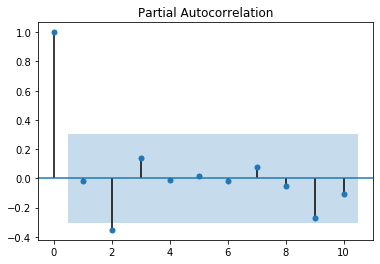

In [23]:
_ = plot_pacf(data_sub_day.loc[data_sub_day['Date'] < date_cutoff, 'mean'], lags=10)

In [24]:
# ljungbox test for autocorrelation
st.ljungbox_(data_sub_day.loc[data_sub_day['Date'] < date_cutoff, 'mean'])

Statistics=10.068, p=0.435
No auto correlation up to lag 10 (fail to reject H0)


#### Hypothesis test for normality

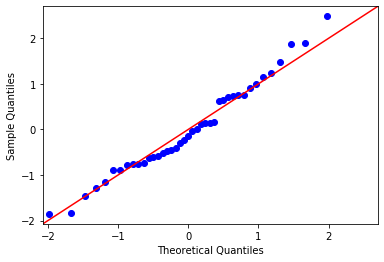

In [25]:
fig = sm.qqplot(data_sub_day.loc[data_sub_day['Date'] < date_cutoff, 'mean'], fit=True, line='45')
plt.show()

In [26]:
# shapiro-wilks test for normality
st.shapiro_wilks_(data_sub_day.loc[data_sub_day['Date'] < date_cutoff, 'mean'], alpha=0.05)

Statistics=0.976, p=0.535
Sample looks Gaussian (fail to reject H0)


In [27]:
# jarque-bera test for normality
st.jarque_bera_(data_sub_day.loc[data_sub_day['Date'] < date_cutoff, 'mean'], alpha=0.05)

Statistics=1.147, p=0.564, skew=0.378, kurt=2.684
Sample looks Gaussian (fail to reject H0)


In [28]:
# If skewness is less than -1 or greater than 1, the distribution is highly skewed.
# If skewness is between -1 and -0.5 or between 0.5 and 1, the distribution is moderately skewed.
# If skewness is between -0.5 and 0.5, the distribution is approximately symmetric.

In [29]:
# Kurtosis is approx 3

#### Get in control mean

In [30]:
# Get in-control mean
data_sub_day.loc[data_sub_day['Date'] < date_cutoff, 'mean'].mean()

139.99635202196174

In [31]:
in_control_mean = data_sub_day.loc[data_sub_day['Date'] < date_cutoff, 'mean'].mean()

#### Get in control moving range

In [32]:
MR = cp.calculate_MR(data_sub_day.loc[data_sub_day['Date'] < date_cutoff, 'mean'])

In [33]:
in_control_sigma = cp.estimate_sigma_from_MR(MR)

In [34]:
in_control_sigma

15.981648744281724

#### Build individual control chart

In [35]:
x_ind_params_df = cp.x_ind_params(x = data_sub_day['mean'], sigma = in_control_sigma, center = in_control_mean)

In [36]:
# Merge with date
x_ind_params_df = pd.concat([data_sub_day.reset_index(drop=True).loc[:, 'Date'], x_ind_params_df], axis=1)

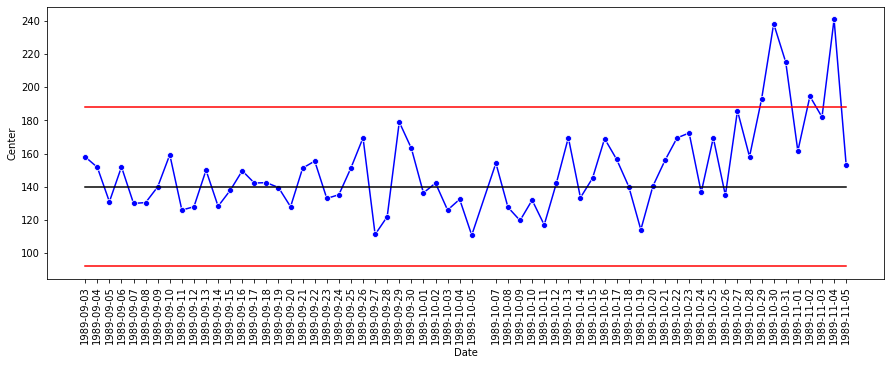

In [37]:
pf.plot_control_chart(
    data = x_ind_params_df,
    index = 'Date',
    obs = 'obs',
    UCL = 'UCL',
    center = 'Center',
    LCL = 'LCL',
    all_dates=True,
    rot=90)

In [38]:
x_ind_params_df['Date'][x_ind_params_df['obs'] >= x_ind_params_df['UCL']]

55   1989-10-29
56   1989-10-30
57   1989-10-31
59   1989-11-02
61   1989-11-04
Name: Date, dtype: datetime64[ns]

#### Build EWMA

In [39]:
ewma_params_df = cp.ewma_params(x = data_sub_day['mean'], sigma=in_control_sigma, alpha=0.1, center=in_control_mean, L=3)

In [40]:
# Merge with date
ewma_params_df = pd.concat([data_sub_day.reset_index(drop=True).loc[:, 'Date'], ewma_params_df], axis=1)

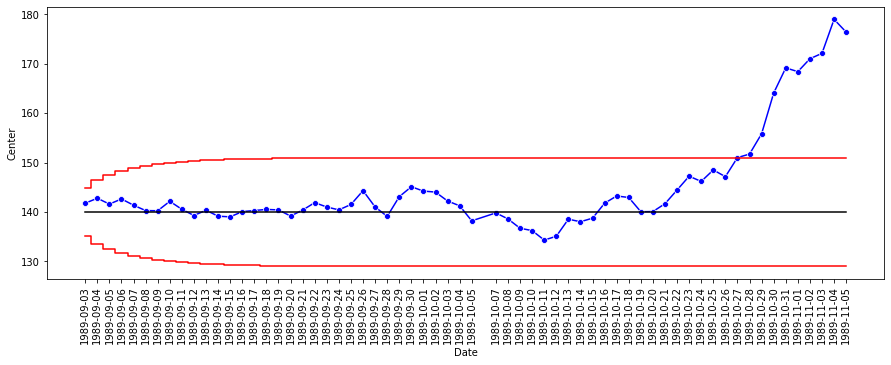

In [41]:
pf.plot_control_chart(
    data = ewma_params_df,
    index = 'Date',
    obs = 'obs',
    UCL = 'UCL',
    center = 'Center',
    LCL = 'LCL',
    all_dates=True,
    rot=90)

In [42]:
ewma_params_df['Date'][ewma_params_df['obs'] >= ewma_params_df['UCL']]

53   1989-10-27
54   1989-10-28
55   1989-10-29
56   1989-10-30
57   1989-10-31
58   1989-11-01
59   1989-11-02
60   1989-11-03
61   1989-11-04
62   1989-11-05
Name: Date, dtype: datetime64[ns]